### Imports

Esta célula de código faz as importações necessária para o funcionamento do projeto

- **os**: Permite a manipulação de sistema de ficheiros e operações em pastas
- **shuntil**: Fornece várias operações, como copiar, mover, remover pastas
- **path**: Fornece classes para manipulação de *paths*
- **image_dataset_from_directory**: Utilizado para carregar um conjunto de dados de imagens a partir de uma pasta
- **keras,layers, models**: Submódulos do Keras, utilizados para construir arquiteturas de modelos de redes neuronais
- **tensorflow**: Biblioteca de código *open-source*, para computação numérica e implementação de algoritmos de aprendizagem
- **EarlyStopping**: Callback para utilizar durante o treino dos modelos para interromper o processo caso não exista melhorias métricas
- **ModelCheckpoint**: Callback para utilizar durante o treino dos modelos para guardar o processo caso não exista melhorias métricas
- **matplotlib**: Biblioteca para criar gráficos e visualizações que ajudam na análise dos resultados do treino dos modelos

In [1]:
import os, shutil
from pathlib import Path
from keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers
from keras import models
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt


2024-06-22 21:01:50.194916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 21:01:51.356651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reunir as imagens
**Atenção**: esta célula de código só é necessaria correr uma vez, apesar de estar em todos os *notebooks*

Nesta célula de código, fazemos a junção de todas as imagens das pastas de treino (*train1*, *train3*, *train4*, *train5*) numa só pasta, chamada de "temp_train", que vai conter todo o conteudo das pastas de treino, assim tendo um dataset único com bastantes imagens.


In [42]:
# Lista de subpastas (train1, train3, etc.)
subfolders = ['train1', 'train3', 'train4', 'train5']

# Criar a estrutura temporária
Path(temp_train_dir).mkdir(parents=True, exist_ok=True)

# Iterar sobre cada subpasta
for subfolder in subfolders:
    subfolder_path = os.path.join(train_dir, subfolder)

    for class_folder in os.listdir(subfolder_path):
        class_folder_path = os.path.join(subfolder_path, class_folder)

        if os.path.isdir(class_folder_path):
            # Caminho destino para mover os arquivos
            dest_path = os.path.join(temp_train_dir, class_folder)

            if not os.path.exists(dest_path):
                os.makedirs(dest_path)

            # Mover todos os arquivos da subpasta para a pasta destino
            for filename in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, filename)
                shutil.copy(file_path, dest_path)

### Carregar as imagens

Esta célula de código define váriaveis aos caminhos das diretorias

Após ser "corrido" a célula de código acima, é possivel carregar a nova pasta chamada de temp_train juntamente com as pastas de validação, e de testes.


In [2]:
temp_train_dir = 'temp_train'
validation_dir = 'train2'
test_dir = 'test'

### Definir tamanho de imagem e tamanho de batch

Nesta célula de código é definido:
- Uma IMG_SIZE = 32, sendo assim, define o tamanho da imagem para 32x32 pixeis, sendo um tamanho relativemente pequeno, a velocidade do treino do modelo vai ser mais rapido, pois este possui menos informação do que por exemplo num IMG_SIZE = 150 (150x150 pixeis)
- Um BATCH_SIZE = 32, que define o tamanho do lote de dados que serão "alimentados" no modelo durante o treino.
- O conjunto de dados dos diferentes datasets, nomeadamente o temp_train_dir, o validation_dir e o test_dir.
- O label_mode como categorical, pois sendo o nosso problema de classificação, é o mais indicado.

In [3]:
IMG_SIZE = 32
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
  temp_train_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

validation_dataset = image_dataset_from_directory(
  validation_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_dataset = image_dataset_from_directory(
  test_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 40000 files belonging to 10 classes.


2024-06-22 21:02:06.266838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:02:06.318398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:02:06.318456: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:02:06.322150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:02:06.322286: I external/local_xla/xla/stream_executor

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


Found 40000 files belonging to 10 classes.

Found 10000 files belonging to 10 classes.

Found 10000 files belonging to 10 classes.

### Print do test_dataset

Nesta célula conseguimos rapidamente ver as dimensões dos lotes, certificando que foram corretamente carregados.

In [4]:
for data_batch, labels_batch in test_dataset:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (32, 32, 32, 3)
Labels batch shape: (32, 10)


Data batch shape: (32, 32, 32, 3)

Labels batch shape: (32, 10)

### Exibir imagens

É feito a conversão de cada elemento do lote 'data_batch[i]' e converte-o para um *unsigned integer* de 8 *bits*, algo comum em imagens.

Nesta célula conseguimos visualizar as primeiras 5 imagens do primeiro batch de dados do conjunto de treinamento, conseguindo assim verificar visualmente que as entradas dos dados a serem processados estão corretos.



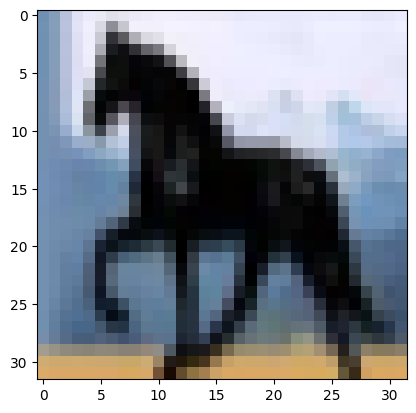

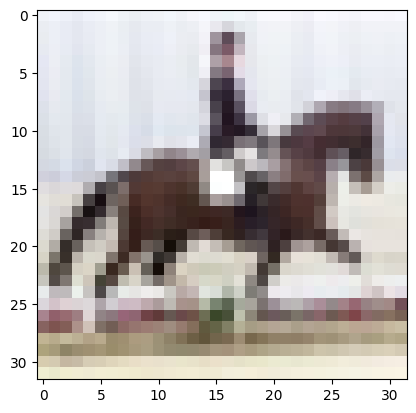

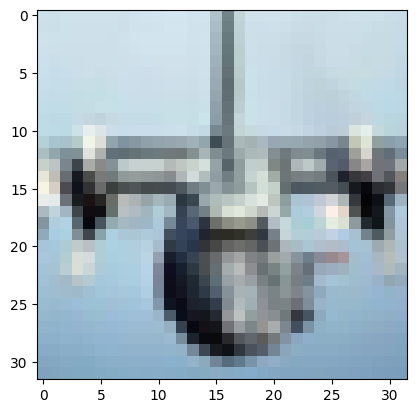

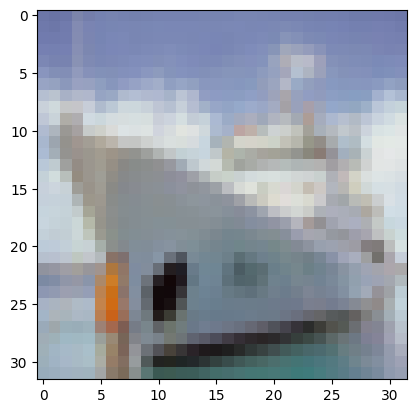

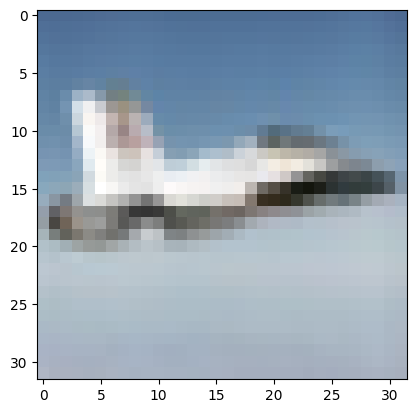

2024-06-21 14:30:29.393811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
for data_batch, _ in train_dataset.take(1):
  for i in range(5):
    plt.imshow(data_batch[i].numpy().astype("uint8"))
    plt.show()

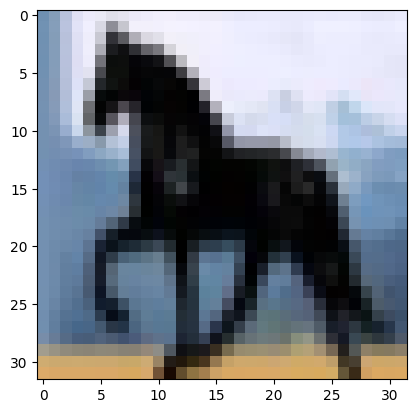
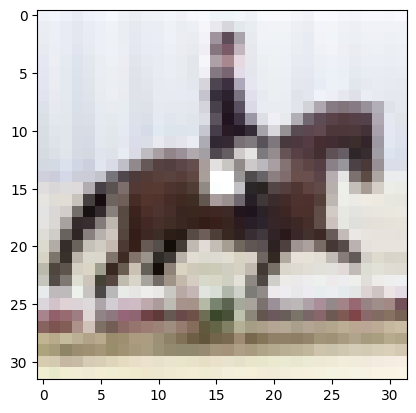
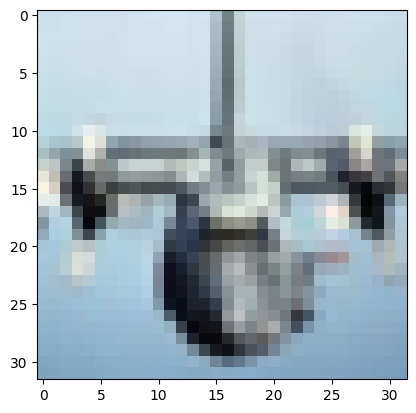
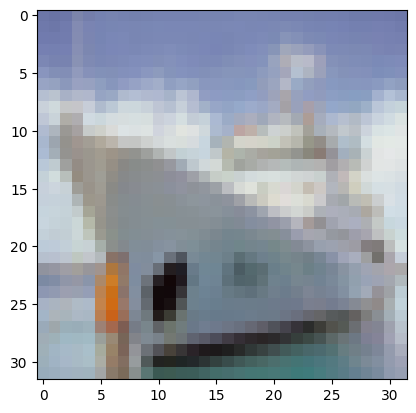
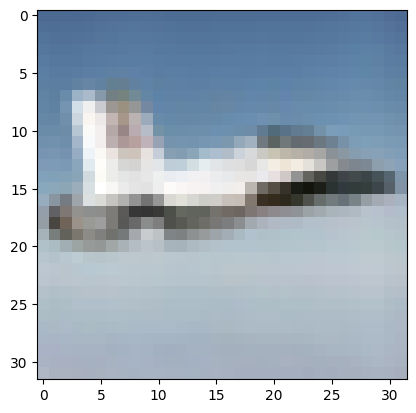


### Construir o modelo

Nesta célula de código definimos:

- No input a altura com IMG_SIZE, a largura com IMG_SIZE, e finalmente o *RGB*, com 3 (os três canais de cor)
- Um *rescaling* para normalizar os valores dos pixeis de 0 a 255 para 0 a 1, fazemos isto a dividir cada pixel por 255.
- Adicionamos as camadas convolucionais, seguidas por outras camadas de max pooling.
- O Conv2D aplica convolução com 32 filtros de tamanho 3x3
- O MaxPooling2D reduz a dimensionalidade pela metade
- Repetimos este procedimento três vezes, seguidas das camadas de max pooling para conseguir extrair caracteristicas das imagens e reduzir a dimensionalidade das mesmas
- De seguida com o **layers.Flatten()(x)** transformamos os dados de saida das camadas convulacionais num vetor unidimensional.
- Com o **layers.Dense(512, activation="relu")(x)** adicionamos uma camada com 512 unidades e a função **relu**, isto permite que a rede aprenda combinações mais complexas das caracteristicas extraidas.
- Depois com o **layers.Dense(10,activation="softmax")(x)** definimos a camada de saida, com 10 unidades (número de sub-pastas em cada pasta de treino), e ainda utilizamos a ativação **softmax** que normalmente usada para problemas de classificação.
- Por fim, criamos o novo modelo com o **keras.Model(inputs=inputs, outputs=outputs)**, onde os *inputs* são as camadas de entrada e os *outputs* são as camadas de saida anteriormente definidas

In [5]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### Compilar o modelo

Nesta célula de código, configuramos o processo de compilação do modelo construido anteriormente.

- **loss='categorical_crossentropy'** utilizamos a função de perda 'categorical_crossentropy', pois é uma função utilizada normalmente em problemas de classificação
- **optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)** aqui escolhemos o otimizador RMSprop, com uma taxa de *learning* de 0.0001
-  **metrics=['acc']** por fim, definimos a métrica para avaliar o desempenho do modelo durante o treino para ser a *accuracy* 



In [6]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
  metrics=['acc'])

### Treinar o modelo

Nesta célula de código implementamos:


- EarlyStopping é definido para este monitorizar a 'val_loss', e se esta não tiver alterações significativas após 5 *epochs*, vai fazer a pausa do algoritmo.

- Definimos o model_checkpoint para este guardar **apenas** os melhores resultados, conforme o valor da 'val_loss'. Este guarda o melhor resultado dentro da pasta 'models' com o nome adequado.

- Iniciamos o treino do modelo com o conjunto de dados de treinamento, definido ainda o número de epochs como 30, e avaliando o mesmo com o conjunto de dados de validaçao.

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='models/Projeto_S_from_scratch_sem_data_augmentation_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

callbacks = [early_stopping, model_checkpoint]

history = model.fit(
    train_dataset,
    epochs=30,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_dataset
)

Epoch 1/30


I0000 00:00:1719086605.221038  164706 service.cc:145] XLA service 0x7f0e4c008f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719086605.225737  164706 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-22 21:03:25.288289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-22 21:03:25.511399: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-22 21:03:27.240079: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[32,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation

  42/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.1268 - loss: 2.3029  

I0000 00:00:1719086610.987497  164706 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - acc: 0.2385 - loss: 2.0616 - val_acc: 0.3743 - val_loss: 1.7129
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - acc: 0.4045 - loss: 1.6330 - val_acc: 0.4245 - val_loss: 1.5452
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - acc: 0.4679 - loss: 1.4745 - val_acc: 0.4701 - val_loss: 1.4589
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - acc: 0.5091 - loss: 1.3750 - val_acc: 0.5077 - val_loss: 1.3623
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - acc: 0.5352 - loss: 1.3019 - val_acc: 0.5365 - val_loss: 1.2916
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - acc: 0.5610 - loss: 1.2373 - val_acc: 0.5598 - val_loss: 1.2394
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.5854 - loss: 1.1793 - val_acc: 0.5575 - val_loss: 1.2628
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - acc: 0.5984 - loss: 1.1375 - val_acc: 0.6005 - val_loss: 1.1502
Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - acc: 0.2385 - loss: 2.0616 - val_acc: 0.3743 - val_loss: 1.7129

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - acc: 0.4045 - loss: 1.6330 - val_acc: 0.4245 - val_loss: 1.5452

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - acc: 0.4679 - loss: 1.4745 - val_acc: 0.4701 - val_loss: 1.4589

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - acc: 0.5091 - loss: 1.3750 - val_acc: 0.5077 - val_loss: 1.3623

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - acc: 0.5352 - loss: 1.3019 - val_acc: 0.5365 - val_loss: 1.2916

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - acc: 0.5610 - loss: 1.2373 - val_acc: 0.5598 - val_loss: 1.2394

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.5854 - loss: 1.1793 - val_acc: 0.5575 - val_loss: 1.2628

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - acc: 0.5984 - loss: 1.1375 - val_acc: 0.6005 - val_loss: 1.1502

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - acc: 0.6215 - loss: 1.0898 - val_acc: 0.5852 - val_loss: 1.1658

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - acc: 0.6321 - loss: 1.0535 - val_acc: 0.6111 - val_loss: 1.1006

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.6453 - loss: 1.0163 - val_acc: 0.5857 - val_loss: 1.1712

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - acc: 0.6567 - loss: 0.9843 - val_acc: 0.6374 - val_loss: 1.0426

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - acc: 0.6708 - loss: 0.9514 - val_acc: 0.6290 - val_loss: 1.0502

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - acc: 0.6773 - loss: 0.9244 - val_acc: 0.6285 - val_loss: 1.0576

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - acc: 0.6869 - loss: 0.8970 - val_acc: 0.6520 - val_loss: 0.9930

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - acc: 0.6974 - loss: 0.8711 - val_acc: 0.6623 - val_loss: 0.9630

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7051 - loss: 0.8470 - val_acc: 0.6551 - val_loss: 0.9875

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.7133 - loss: 0.8209 - val_acc: 0.6480 - val_loss: 1.0084

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - acc: 0.7227 - loss: 0.7996 - val_acc: 0.6450 - val_loss: 1.0257

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - acc: 0.7320 - loss: 0.7753 - val_acc: 0.6571 - val_loss: 0.9781

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7409 - loss: 0.7525 - val_acc: 0.6773 - val_loss: 0.9321

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7476 - loss: 0.7314 - val_acc: 0.6804 - val_loss: 0.9378

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.7554 - loss: 0.7125 - val_acc: 0.6757 - val_loss: 0.9496

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7617 - loss: 0.6953 - val_acc: 0.6767 - val_loss: 0.9432

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7678 - loss: 0.6727 - val_acc: 0.6899 - val_loss: 0.9164

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7711 - loss: 0.6574 - val_acc: 0.6828 - val_loss: 0.9362

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.7799 - loss: 0.6367 - val_acc: 0.6850 - val_loss: 0.9394

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7866 - loss: 0.6193 - val_acc: 0.6946 - val_loss: 0.9155

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7937 - loss: 0.5981 - val_acc: 0.6743 - val_loss: 0.9874

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.7995 - loss: 0.5834 - val_acc: 0.6968 - val_loss: 0.9217


### Avaliação do modelo

Aqui é representado o val_acc do modelo criado na célula de código anterior, este representa o valor da precisão da classificasão do conjunto de dados de validação

In [8]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7021 - loss: 0.8821
val_acc: 0.694599986076355


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7021 - loss: 0.8821

val_acc: 0.694599986076355

### Guardar o modelo criado

Guardamos o módelo com um nome apropriado, dentro da pasta 'models'

In [9]:
model.save('models/Projeto_S_from_scratch_sem_data_augmentation.keras')

### Carregar o último melhor modelo

Carregamos o **best** modelo que fica guardado numa variavel chamada de loaded_model

De seguida fazemos o summary do mesmo para visualizar a sua arquitetura

In [10]:
loaded_model = tf.keras.models.load_model('models/Projeto_S_from_scratch_sem_data_augmentation_best.keras')

loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,070 (2.75 MB)

 Trainable params: 361,034 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 361,036 (1.38 MB)

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">3</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Rescaling</span>)         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">3</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">30</span>, <span style="color: #00af00; text-decoration-color: #00af00">30</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │           <span style="color: #00af00; text-decoration-color: #00af00">896</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">15</span>, <span style="color: #00af00; text-decoration-color: #00af00">15</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">13</span>, <span style="color: #00af00; text-decoration-color: #00af00">13</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │        <span style="color: #00af00; text-decoration-color: #00af00">18,496</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">6</span>, <span style="color: #00af00; text-decoration-color: #00af00">6</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)       │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │        <span style="color: #00af00; text-decoration-color: #00af00">73,856</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">2</span>, <span style="color: #00af00; text-decoration-color: #00af00">2</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)            │       <span style="color: #00af00; text-decoration-color: #00af00">262,656</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">10</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">5,130</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Total params: </span><span style="color: #00af00; text-decoration-color: #00af00">722,070</span> (2.75 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">361,034</span> (1.38 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Non-trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">0</span> (0.00 B)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Optimizer params: </span><span style="color: #00af00; text-decoration-color: #00af00">361,036</span> (1.38 MB)
</pre>


### Treinar de novo, mas a partir do último melhor modelo

Aqui voltamos a repetir o processo de treinamento com 20 *epochs*, no entanto em vez de começar do "zero" treinamos a partir do último melhor modelo.

Observação: o treinamento para na *epoch* 9 devido ao **EarlyStopping**, foi testado também sem ter o **EarlyStopping** implementado, e os resultados são bastante semelhantes, indicando que após cerca de 35-40 (30 anteriores + 9 agora) *epochs* o modelo tem muitas poucas diferenças.

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True 
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='models/Projeto_S_from_scratch_sem_data_augmentation_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

callbacks = [early_stopping, model_checkpoint]

historyAfter = loaded_model.fit(train_dataset, epochs=20, verbose=1, callbacks=callbacks, validation_data=validation_dataset)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - acc: 0.8178 - loss: 0.5315 - val_acc: 0.6866 - val_loss: 0.9735
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8252 - loss: 0.5152 - val_acc: 0.6933 - val_loss: 0.9619
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - acc: 0.8322 - loss: 0.4991 - val_acc: 0.6992 - val_loss: 0.9373
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8359 - loss: 0.4824 - val_acc: 0.7024 - val_loss: 0.9222
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - acc: 0.8422 - loss: 0.4687 - val_acc: 0.6931 - val_loss: 0.9801
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8484 - loss: 0.4547 - val_acc: 0.6930 - val_loss: 0.9883
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8552 - loss: 0.4367 - val_acc: 0.6996 - val_loss: 0.9610
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.8555 - loss: 0.4245 - val_acc: 0.6960 - val_loss: 1.0032
Epoch 9/20
1250/1250 ━━━

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - acc: 0.8178 - loss: 0.5315 - val_acc: 0.6866 - val_loss: 0.9735

Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8252 - loss: 0.5152 - val_acc: 0.6933 - val_loss: 0.9619

Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - acc: 0.8322 - loss: 0.4991 - val_acc: 0.6992 - val_loss: 0.9373

Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8359 - loss: 0.4824 - val_acc: 0.7024 - val_loss: 0.9222

Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - acc: 0.8422 - loss: 0.4687 - val_acc: 0.6931 - val_loss: 0.9801

Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8484 - loss: 0.4547 - val_acc: 0.6930 - val_loss: 0.9883

Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8552 - loss: 0.4367 - val_acc: 0.6996 - val_loss: 0.9610

Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.8555 - loss: 0.4245 - val_acc: 0.6960 - val_loss: 1.0032

Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - acc: 0.8631 - loss: 0.4071 - val_acc: 0.6948 - val_loss: 1.0164

### Avaliação do modelo treinado apartir do último melhor

- É possivel ver uma pequena melhoria na accuracy do modelo após o "segundo" treinamento

In [14]:
val_loss, val_acc = loaded_model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7122 - loss: 0.8881
val_acc: 0.7024000287055969


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7122 - loss: 0.8881

val_acc: 0.7024000287055969

### Desenhar graficos

É gerado os gráficos com os modelos previamente treinados, tanto com o antes de treinar a partir do ultimo melhor, como com o após treinar o último melhor.

Os graficos mostram a accuracy e a loss, durante o processo de treino e validação ao longo das *epochs*, possibilitando ver o desempenho e o *overfitting*.

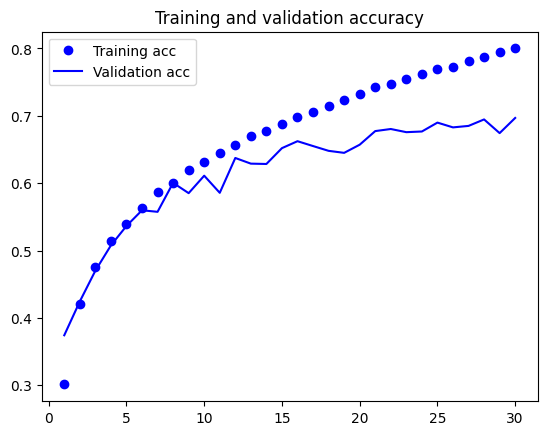

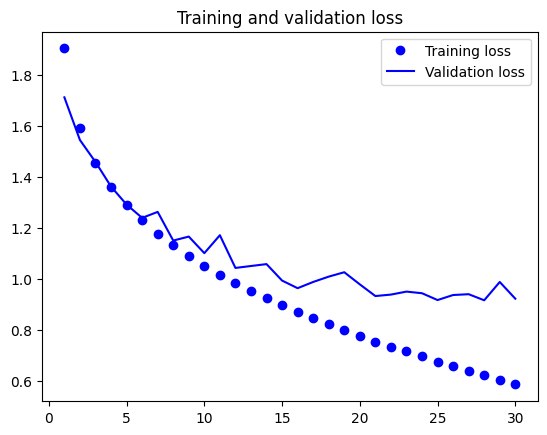

In [15]:
# Gráfico de accuracy ANTES de treinar a partir do ultimo melhor modelo

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

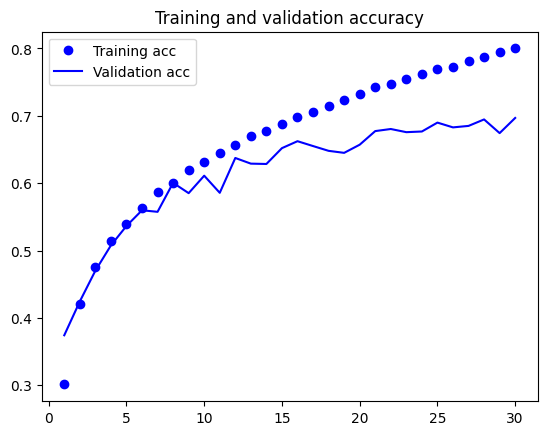
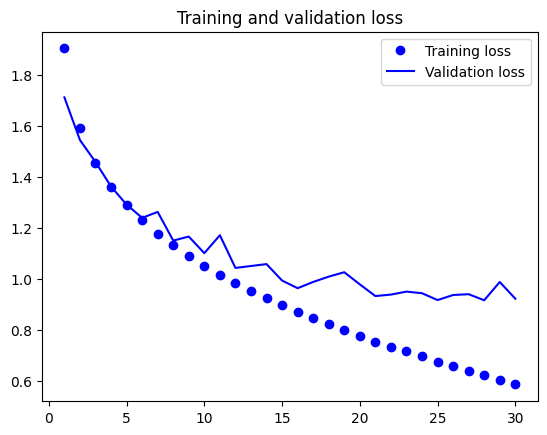

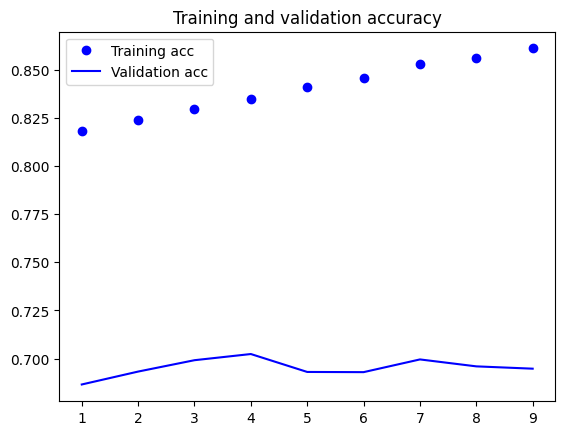

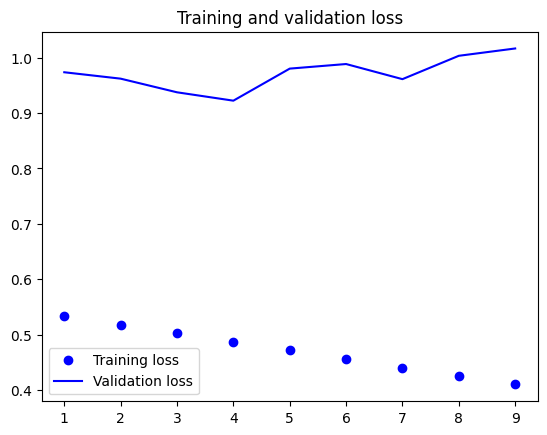

In [16]:
# Gráfico de accuracy DEPOIS de treinar a partir do ultimo melhor modelo

import matplotlib.pyplot as plt

acc = historyAfter.history['acc']
val_acc = historyAfter.history['val_acc']
loss = historyAfter.history['loss']
val_loss = historyAfter.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

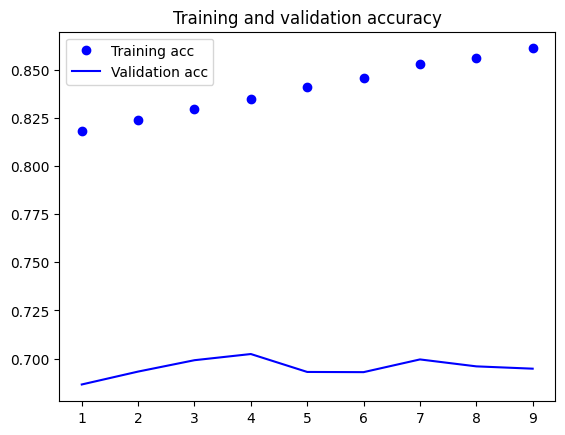
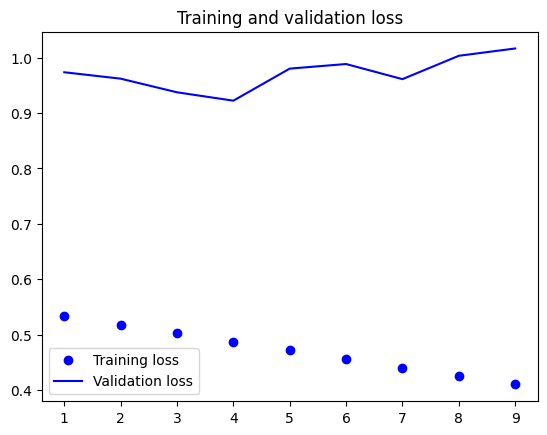




### Relatório

#### Objetivo

Neste *notebook* desenvolvemos uma rede convolucional básica composta pelas seguintes camadas:

- **Camada de entrada** que recebe imagens com dimensão 32x32 pixels e 3 canais de cor (RGB);
- **Camada de normalização dos dados de entrada** que reescala os valores dos *pixels* da imagem para um intervalo [0, 1] ou [-1, 1];
- **Camada convolucional** com 32 filtros, cada um de tamanho 3x3;
- **Camada de maxpooling** com janelas de pooling 2x2;
- **Camada convolucional** com 64 filtros, cada um de tamanho 3x3;
- **Camada de maxpooling** com janelas de pooling 2x2;
- **Camada convolucional** com 128 filtros, cada um de tamanho 3x3;
- **Camada de maxpooling** com janelas de pooling 2x2;
- **Camada flatten** que agrupa todo o output shape numa matriz de uma só dimensão;
- **Camada dense** que ajuda a aprender representações complexas dos dados de entrada;
- **Camada dense** é a camada de saída que representa as 10 classes de saída.

#### Desenvolvimento

Inicialmente começamos por usar uma CNN composta por 4 camadas convolucionais e 4 camadas de MaxPooling:

![Sem título.png](<attachment:Sem título.png>)

Como consequência, recebemos um erro que acusava o feature map de ser inválido, uma vez que inicialmente as imagens têm um tamanho 32x32 e com este número de camadas reduzia o feature map a um tamanho inválido (from_scratch_sem_data_augmentation_v1).

Tendo isto em conta, desenvolvemos um from_scratch_sem_data_augmentation_v2 novo na qual decidimos reduzir o CNN para 3 camadas convolucionais e 2 camadas MaxPooling, que gerava um feature map de 4x4:

| Layer (type)                   | Output Shape         | Param #      |
|--------------------------------|----------------------|--------------|
| input_layer (InputLayer)       | (None, 32, 32, 3)    | 0            |
| rescaling (Rescaling)          | (None, 32, 32, 3)    | 0            |
| conv2d (Conv2D)                | (None, 30, 30, 32)   | 896          |
| max_pooling2d (MaxPooling2D)   | (None, 15, 15, 32)   | 0            |
| conv2d_1 (Conv2D)              | (None, 13, 13, 64)   | 18,496       |
| max_pooling2d_1 (MaxPooling2D) | (None, 6, 6, 64)     | 0            |
| conv2d_2 (Conv2D)              | (None, 4, 4, 128)    | 73,856       |
| flatten (Flatten)              | (None, 2048)         | 0            |
| dense (Dense)                  | (None, 512)          | 1,049,088    |
| dense_1 (Dense)                | (None, 10)           | 5,130        |

Com esta rede, obtivemos os seguintes resultados:

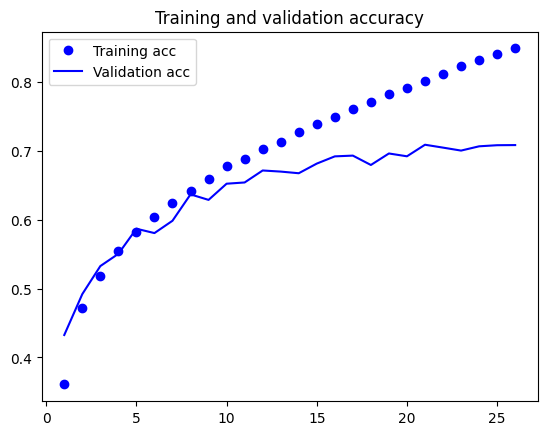

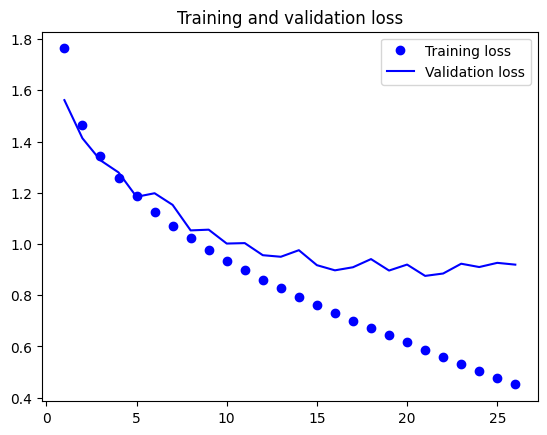

**val_acc:** 0.70660001039505

Ao tentar procurar uma melhor accuracy decidimos criar a versão final (from_scratch_sem_data_augmentation) em que nesta utilizamos 3 camadas convolucionais e 3 camadas MaxPooling, resultando num feature map 2x2:

| Layer (type)                   | Output Shape          | Param #   |
|--------------------------------|-----------------------|-----------|
| input_layer_1 (InputLayer)     | (None, 32, 32, 3)     | 0         |
| rescaling_1 (Rescaling)        | (None, 32, 32, 3)     | 0         |
| conv2d_3 (Conv2D)              | (None, 30, 30, 32)    | 896       |
| max_pooling2d_3 (MaxPooling2D) | (None, 15, 15, 32)    | 0         |
| conv2d_4 (Conv2D)              | (None, 13, 13, 64)    | 18,496    |
| max_pooling2d_4 (MaxPooling2D) | (None, 6, 6, 64)      | 0         |
| conv2d_5 (Conv2D)              | (None, 4, 4, 128)     | 73,856    |
| max_pooling2d_5 (MaxPooling2D) | (None, 2, 2, 128)     | 0         |
| flatten_1 (Flatten)            | (None, 512)           | 0         |
| dense_2 (Dense)                | (None, 512)           | 262,656   |
| dense_3 (Dense)                | (None, 10)            | 5,130     |


Obtivemos os seguintes resultados, que não mostraram muita diferença:

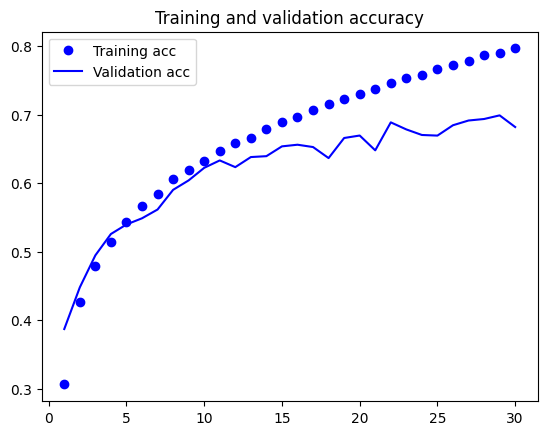

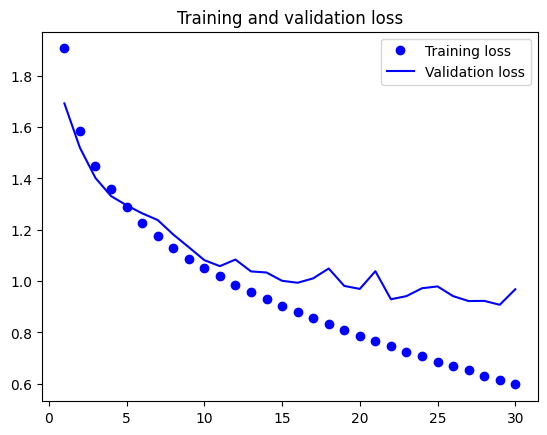

**val_acc:** 0.694599986076355

Decidimos carregar o melhor modelo obtido (Projeto_S_from_scratch_sem_data_augmentation_best.keras) depois do treino completo e tentar melhorá-lo, mas foi abortado pelo earlyStopping porque no espaço de 5 epochs não melhorou significantemente o val_loss, o que gerou os seguintes resultados:

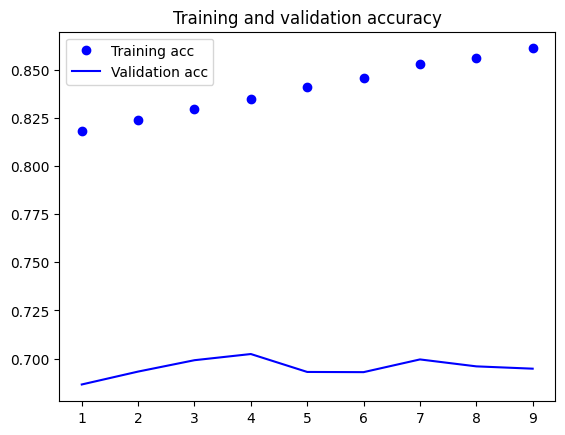

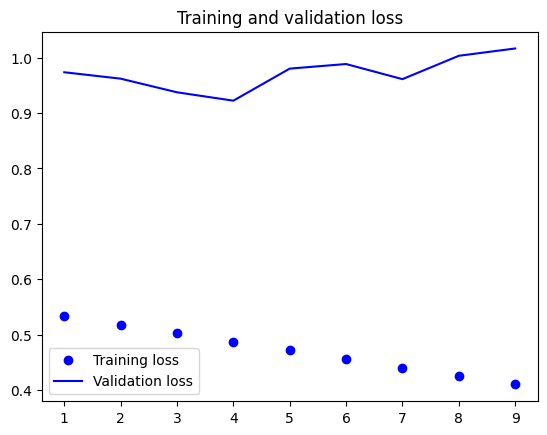

**val_acc:** 0.7024000287055969

#### Conclusão

Como se comprova pelos gráficos apresentados no desenvolvimento os resultados das *accuracies* apresentam um problema de *overfitting*, isto é, o modelo ajustou-se muito bem aos dados de treino que o seu desempenho em novos dados (dados de validação) piorou. Logo, o modelo aprende os padrões dos dados de treino ao invés dos padrões gerais que poderiam ser aplicados a dados não vistos. Isso resulta num modelo que tem alta precisão no conjunto de treino, mas baixo desempenho nos dados do conjunto de validação.



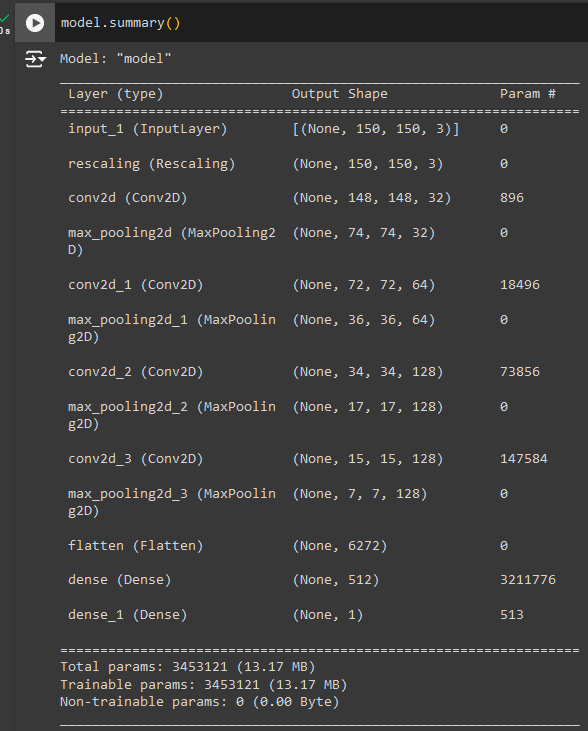